In [85]:
import numpy as np
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import statsmodels.formula.api as sm

In [2]:
detsX = pd.read_csv("../input/RegularSeasonDetailedResults.csv")
compX = pd.read_csv("../input/RegularSeasonCompactResults.csv")
compY = pd.read_csv("../input/TourneyCompactResults.csv")

In [3]:
#Set up ELO basis
detsX['WELO'] = detsX.apply(lambda row: 1200, axis=1)
detsX['LELO'] = detsX.apply(lambda row: 1200, axis=1)


In [4]:
#Engineer Features
detsX['Ptdiff'] = detsX.apply(lambda row: row['Wscore']-row['Lscore'], axis=1)

In [6]:
#Create ELO Scores
##Create initial ELOs for all teams (1200)
#ELOs = pd.concat(compY[['Wteam','Lteam']][compY['Season'] == 2016],compY[['Lteam','Wteam']][compY['Season'] == 2016])
ELOs = compX[['Wteam','Lteam']].append(compX[['Lteam','Wteam']][compX['Season'] == 2016])
ELOs['ELO'] = ELOs.apply(lambda row: 1200, axis=1)
ELOs = ELOs.drop('Lteam', 1)
ELOs['team'] = ELOs['Wteam']
ELOs = ELOs.drop('Wteam', 1)
ELOs = ELOs[['team','ELO']]
ELOs=ELOs.groupby('team').mean()
##Account for team churn year-to-year

In [7]:
def ELOCalc(Wteam, Lteam):
    WK=20
    LK=20
    WR_old = ELOs.loc[Wteam].ELO
    LR_old = ELOs.loc[Lteam].ELO
    WR_new = WR_old + WK*(1-(WR_old/(WR_old+LR_old)))
    LR_new = LR_old + LK*(0-(LR_old/(WR_old+LR_old)))
    #ELOs.loc[Wteam, 'ELO'] = WR_new
    #ELOs.loc[Lteam, 'ELO'] = LR_new
    return [WR_new, LR_new]

In [8]:
##Simulate ELO
##Setup data to ELO
#Time it
start = time.time()

for year in range(2010,2017):
    games = detsX[detsX['Season']==year]
    dayArray = games['Daynum'].unique()
    for day in dayArray:
        for Wteam, Lteam in zip(games['Wteam'][(games['Daynum'] == day)].values.tolist(),
                            games['Lteam'][(games['Daynum'] == day)].values.tolist()):
            #Set Historical ELO
            detsX.loc[(detsX.Season == year) & (detsX.Daynum == day) & (detsX.Wteam == Wteam),'WELO'] = ELOs.loc[Wteam].ELO
            detsX.loc[(detsX.Season == year) & (detsX.Daynum == day) & (detsX.Wteam == Wteam),'LELO'] = ELOs.loc[Lteam].ELO
            #Update Ongoing ELO
            ELOs.loc[Wteam, 'ELO'] = ELOCalc(Wteam, Lteam)[0]
            ELOs.loc[Lteam, 'ELO'] = ELOCalc(Wteam, Lteam)[1]
            
duration = time.time() - start
print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

2 Minute(s), 58 Second(s).


In [9]:
max(ELOs.ELO)

2464.3480372803274

In [21]:
#Add ELODiff Metric
detsX['ELODiff'] = detsX.apply(lambda row: row['WELO'] - row['LELO'] , axis=1)

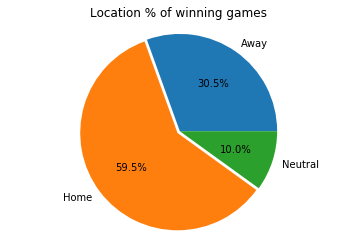

In [22]:
#Looking into the variables that may affect the ELO E metric
useGames = detsX[(detsX['Season']>=2010)]
##Checking Away vs Home
labels = ['Away','Home','Neutral']
sizes = [detsX[detsX['Wloc'] == 'A'].shape[0],detsX[detsX['Wloc'] == 'H'].shape[0],detsX[detsX['Wloc'] == 'N'].shape[0]]
plt.pie(sizes,explode=(0,0.03,0),labels=labels,autopct='%1.1f%%')
plt.axis('equal')
plt.title('Location % of winning games')
plt.show()

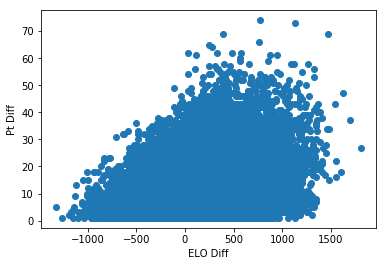

In [45]:
#Checking ELO relevance to ptDiff
x=useGames['ELODiff'][useGames['Season']>2010] #Using onlyu 2011+ data so the ELO is meaningful
y=useGames['Ptdiff'][useGames['Season']>2010]
plt.scatter(x,y)
plt.xlabel('ELO Diff')
plt.ylabel('Pt Diff')
plt.show()

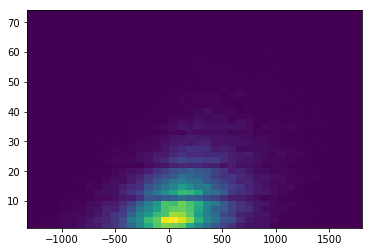

In [46]:
##Scatter plot is too dense, turning it into a heat map
heatmap, xedges, yedges = np.histogram2d(x, y, bins=40)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
plt.show()

Coefficients: 
 [ 0.0080826]
Mean squared error: 74.07
Variance score: 0.10


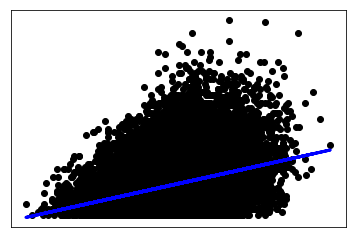

In [84]:
##Looks promising. Let's see how a quick linear regression takes
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
npX = x.as_matrix()[:, np.newaxis]
npY = y.as_matrix()

regr.fit(npX, npY)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(npX) - npY) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(npX, npY))

# Plot outputs
plt.scatter(npX, npY,  color='black')
plt.plot(npX, regr.predict(npX), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [101]:
#More in depth summary statistics on OLS
result = sm.ols(formula="Ptdiff ~ ELODiff", data=useGames[['Ptdiff','ELODiff']]).fit()
print(result.params)
print(result.summary())

Intercept    10.840158
ELODiff       0.008091
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                 Ptdiff   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     3437.
Date:                Sat, 04 Mar 2017   Prob (F-statistic):               0.00
Time:                        12:45:58   Log-Likelihood:            -1.3319e+05
No. Observations:               37167   AIC:                         2.664e+05
Df Residuals:                   37165   BIC:                         2.664e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------

In [102]:
resultHome = sm.ols(formula="Ptdiff ~ ELODiff", data=useGames[['Ptdiff','ELODiff']][useGames['Wloc'] == 'H']).fit()
print(resultHome.params)
print(resultHome.summary())
resultAway = sm.ols(formula="Ptdiff ~ ELODiff", data=useGames[['Ptdiff','ELODiff']][useGames['Wloc'] == 'A']).fit()
print(resultAway.params)
print(resultAway.summary())

Intercept    12.117424
ELODiff       0.009662
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                 Ptdiff   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     2642.
Date:                Sat, 04 Mar 2017   Prob (F-statistic):               0.00
Time:                        12:47:30   Log-Likelihood:                -79747.
No. Observations:               21844   AIC:                         1.595e+05
Df Residuals:                   21842   BIC:                         1.595e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------

In [113]:
resultAway = sm.ols(formula="Wfgm ~ Wstl + Wfga", data=useGames[['Wfgm','Wfga', 'Wstl']][useGames['Wloc'] == 'A']).fit()
print(resultAway.params)
print(resultAway.summary())

Intercept    6.126039
Wstl        -0.044409
Wfga         0.360677
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   Wfgm   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     3251.
Date:                Sat, 04 Mar 2017   Prob (F-statistic):               0.00
Time:                        13:24:08   Log-Likelihood:                -30480.
No. Observations:               11471   AIC:                         6.097e+04
Df Residuals:                   11468   BIC:                         6.099e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------

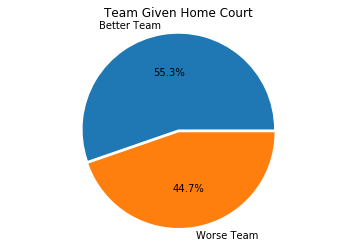

In [15]:
#Home court advantage appears to matter, but are there mitigating factors?
##Is the better team more likely to get home court?
betterHomes = (detsX[(detsX['WELO']>detsX['LELO']) & (detsX['Wloc'] == 'H')].shape[0] + 
               detsX[(detsX['WELO']<detsX['LELO']) & (detsX['Wloc'] == 'A')].shape[0])

worseHomes = (detsX[(detsX['WELO']<detsX['LELO']) & (detsX['Wloc'] == 'H')].shape[0] + 
               detsX[(detsX['WELO']>detsX['LELO']) & (detsX['Wloc'] == 'A')].shape[0])
sizes = [betterHomes, worseHomes]
labels = ['Better Team', 'Worse Team']
plt.pie(sizes,explode=(0,0.03),labels=labels,autopct='%1.1f%%')
plt.axis('equal')
plt.title('Team Given Home Court')
plt.show()

In [ ]:
#Set up DF to use ELO instead of Winning team as identifier
def locReverse(loc):
    if loc.any() == 'A':
        return 'H'
    elif loc.any() == 'H':
        return 'A'
    else:
        return 'N'

(useGames['Hteam'],useGames['Hscore'],useGames['Hloc'],useGames['Hfgm'],useGames['Hfga'],
 useGames['Hfgm3'],useGames['Hfga3'],useGames['Hfta'],useGames['Hor'],useGames['Hdr'],
 useGames['Hast'],useGames['Hto'],useGames['Hstl'],useGames['Hblk'],useGames['Hpf'],
 useGames['Loteam'],useGames['Loscore'],useGames['Loloc'],useGames['Lofgm'],useGames['Lofga'],
 useGames['Lofgm3'],useGames['Lofga3'],useGames['Lofta'],useGames['Loor'],useGames['Lodr'],
 useGames['Loast'],useGames['Loto'],useGames['Lostl'],useGames['Loblk'],useGames['Lopf']
) = zip(*useGames.apply(lambda row: 
                        (useGames['Wteam'],useGames['Wscore'],useGames['Wloc'],useGames['Wfgm'],useGames['Wfga'],
                         useGames['Wfgm3'],useGames['Wfga3'],useGames['Wfta'],useGames['Wor'],useGames['Wdr'],
                         useGames['Wast'],useGames['Wto'],useGames['Wstl'],useGames['Wblk'],useGames['Wpf'],
                         useGames['Lteam'],useGames['Lscore'],locReverse(useGames['Wloc']),useGames['Lfgm'],useGames['Lfga'],
                         useGames['Lfgm3'],useGames['Lfga3'],useGames['Lfta'],useGames['Lor'],useGames['Ldr'],
                         useGames['Last'],useGames['Lto'],useGames['Lstl'],useGames['Lblk'],useGames['Lpf'])
                        if row['WELO'] > row['LELO'] else 
                        (useGames['Lteam'],useGames['Lscore'],locReverse(useGames['Wloc']),useGames['Lfgm'],useGames['Lfga'],
                         useGames['Lfgm3'],useGames['Lfga3'],useGames['Lfta'],useGames['Lor'],useGames['Ldr'],
                         useGames['Last'],useGames['Lto'],useGames['Lstl'],useGames['Lblk'],useGames['Lpf'],
                         useGames['Wteam'],useGames['Wscore'],useGames['Wloc'],useGames['Wfgm'],useGames['Wfga'],
                         useGames['Wfgm3'],useGames['Wfga3'],useGames['Wfta'],useGames['Wor'],useGames['Wdr'],
                         useGames['Wast'],useGames['Wto'],useGames['Wstl'],useGames['Wblk'],useGames['Wpf']),
                        axis=1))


#useGames['LoTeam'] = useGames.apply(lambda row: row['Lteam'] if row['WELO'] > row['LELO'] else row['Wteam'],axis=1)


In [142]:
list(useGames)

['Season',
 'Daynum',
 'Wteam',
 'Wscore',
 'Lteam',
 'Lscore',
 'Wloc',
 'Numot',
 'Wfgm',
 'Wfga',
 'Wfgm3',
 'Wfga3',
 'Wftm',
 'Wfta',
 'Wor',
 'Wdr',
 'Wast',
 'Wto',
 'Wstl',
 'Wblk',
 'Wpf',
 'Lfgm',
 'Lfga',
 'Lfgm3',
 'Lfga3',
 'Lftm',
 'Lfta',
 'Lor',
 'Ldr',
 'Last',
 'Lto',
 'Lstl',
 'Lblk',
 'Lpf',
 'WELO',
 'LELO',
 'Ptdiff',
 'ELODiff',
 'HighTeam',
 'LowTeam',
 'HTeam',
 'LoTeam',
 'H',
 'L',
 ('H', 'L'),
 ('G', 'P'),
 'T',
 'Hteam',
 'Hscore',
 'Hloc',
 'Hfgm',
 'Hfga']

Coefficients: 
 [ 938.23786125]
Mean squared error: 2548.07
Variance score: 0.47


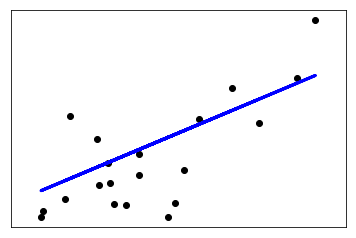

In [65]:
# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(diabetes_X_test) - diabetes_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(diabetes_X_test, diabetes_y_test))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, regr.predict(diabetes_X_test), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [66]:
diabetes_X_train

array([[ 0.06169621],
       [-0.05147406],
       [ 0.04445121],
       [-0.01159501],
       [-0.03638469],
       [-0.04069594],
       [-0.04716281],
       [-0.00189471],
       [ 0.06169621],
       [ 0.03906215],
       [-0.08380842],
       [ 0.01750591],
       [-0.02884001],
       [-0.00189471],
       [-0.02560657],
       [-0.01806189],
       [ 0.04229559],
       [ 0.01211685],
       [-0.0105172 ],
       [-0.01806189],
       [-0.05686312],
       [-0.02237314],
       [-0.00405033],
       [ 0.06061839],
       [ 0.03582872],
       [-0.01267283],
       [-0.07734155],
       [ 0.05954058],
       [-0.02129532],
       [-0.00620595],
       [ 0.04445121],
       [-0.06548562],
       [ 0.12528712],
       [-0.05039625],
       [-0.06332999],
       [-0.03099563],
       [ 0.02289497],
       [ 0.01103904],
       [ 0.07139652],
       [ 0.01427248],
       [-0.00836158],
       [-0.06764124],
       [-0.0105172 ],
       [-0.02345095],
       [ 0.06816308],
       [-0

In [67]:
diabetes_y_train

array([ 151.,   75.,  141.,  206.,  135.,   97.,  138.,   63.,  110.,
        310.,  101.,   69.,  179.,  185.,  118.,  171.,  166.,  144.,
         97.,  168.,   68.,   49.,   68.,  245.,  184.,  202.,  137.,
         85.,  131.,  283.,  129.,   59.,  341.,   87.,   65.,  102.,
        265.,  276.,  252.,   90.,  100.,   55.,   61.,   92.,  259.,
         53.,  190.,  142.,   75.,  142.,  155.,  225.,   59.,  104.,
        182.,  128.,   52.,   37.,  170.,  170.,   61.,  144.,   52.,
        128.,   71.,  163.,  150.,   97.,  160.,  178.,   48.,  270.,
        202.,  111.,   85.,   42.,  170.,  200.,  252.,  113.,  143.,
         51.,   52.,  210.,   65.,  141.,   55.,  134.,   42.,  111.,
         98.,  164.,   48.,   96.,   90.,  162.,  150.,  279.,   92.,
         83.,  128.,  102.,  302.,  198.,   95.,   53.,  134.,  144.,
        232.,   81.,  104.,   59.,  246.,  297.,  258.,  229.,  275.,
        281.,  179.,  200.,  200.,  173.,  180.,   84.,  121.,  161.,
         99.,  109.,